# Introduction à pytorch

Ce notebook commence par une introduction à pytorch qui est la library la plus utilisée actuellement dans le domaine du deep learning.  
Tout d'abord, reprenons notre réseau de neurones du notebook précédent mais implémentons le en pytorch. 

In [2]:
import random
import numpy as np 
import matplotlib.pyplot as plt

# Import classiques des utilisateurs de pytorch 
import torch 
import torch.nn as nn
import torch.nn.functional as F

### Dataset et Dataloader

On va reconstruire un dataset de manière similaire au notebook précédent. Il faut aussi convertir les X et y en tensor (équivalent de Value de micrograd).

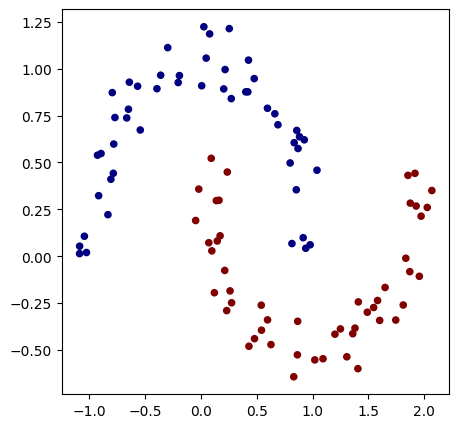

In [5]:
# Initialisation du dataset 
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.1)
X=torch.tensor(X).float() # Conversion en tensor pytorch (équivalent de Value)
y=torch.tensor(y).float() # Conversion en tensor pytorch
y = y*2 - 1 

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

Maintenant, profitons des fonctionnalités de pytorch pour créer notre dataset et notre dataloader. Le dataset regroupe simplement les entrées et les labels alors que le dataloader permet de simplifier l'utilisation de la descente de gradient stochastique et obtenir directement un *mini-batch* de données aléatoire provenant du dataset (le dataloader est un itérateur).

In [6]:
from torch.utils.data import TensorDataset, DataLoader
# Création d'un dataset qui stocke les couples de valeurs X,y
dataset = TensorDataset(X, y)

# Création d'un dataloader qui permet de gérer automatiquement les mini-batchs pour la descente de gradient stochastique. 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Pour en apprendre plus sur le dataset et le dataloader, vous pouvez consulter la [documentation de pytorch](https://pytorch.org/docs/stable/index.html).

### Construction du modèle

Maintenant, construisons notre modèle de 2 couches cachées. 

Pour cela, nous allons construire une classe mlp qui hérite de la classe [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Ensuite, nous construisons nos couches du réseau grâce à la fonction [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)(in_features,out_features) qui construit une couche entièrement connectée prenant en entrée in_features et renvoyant en sortie out_features. C'est une couche de out_features neurones connectée à in_features entrées. 

In [7]:
class mlp(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(2,16) # première couche cachée 
    self.fc2=nn.Linear(16,16) # seconde couche cachée 
    self.fc3=nn.Linear(16,1) # couche de sortie
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.fc1(x)) # le F.relu permet d'appliquer la fonction d'activation ReLU sur la sortie de notre couche 
    x=F.relu(self.fc2(x))
    output=self.fc3(x)
    return output

In [8]:
model = mlp() # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

mlp(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
Nombre de paramètres 337


On a bien le même nombre de paramètres que dans le notebook précédent où on avait utilisé micrograd.

### Fonction de perte

En pytorch, certaines fonctions de perte sont déjà implementées dans la library. Avant d'implémenter votre propre fonction, je vous invite à vérifier si celle-ci existe déjà.  

Ici, nous allons utiliser la fonction torch.nn.MSELoss de pytorch. Il s'agit de la perte suivante :  
$\text{MSE}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$   
où $y_i$ est la valeur réelle (label), $\hat{y}_i$ est la valeur prédite et $n$ est nombre total d'exemples du *mini-batch*. 

En pytorch, cette fonction de perte s'implémente facilement : 

In [10]:
criterion=torch.nn.MSELoss()

### Entraînement 

Pour l'entraînement, définissons les hyper-paramètres et l'optimizer.  
L'[optimizer](https://pytorch.org/docs/stable/optim.html) est une classe pytorch qui spécifie la méthode de mise à jour des poids lors de l'entraînement (mise à jour des poids du modèle et learning rate). Il existe plusieurs d'optimizer : SGD, Adam, Adagrad, RMSProp, etc...  
Nous utilisons SGD (Stochastic Gradient Descent) pour reproduire les conditions d'entraînement du notebook précédent mais, en pratique, on préfère souvent utiliser Adam (Adaptive Moment Estimation).  
Pour en savoir plus sur les optimizers et leurs différences, vous pouvez consulter le cours bonus sur les optimizers, la [documentation pytorch](https://pytorch.org/docs/stable/optim.html) ou le [blogpost](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/).

In [11]:
# Hyper-paramètres
epochs = 100 # Nombre de fois où l'on parcoure l'ensemble des données d'entraînement
learning_rate=0.1
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


On peut également utiliser un scheduler qui a pour fonction de modifier la valeur du learning rate au cours de l'entraînement. Cela peut permettre d'accélerer la convergence en commençant avec un learning rate important et en le réduisant au cours de l'entraînement.  
Pour avoir un learning rate qui diminue au cours de l'entraînement comme dans l'exemple micrograd, on peut utiliser [LinearLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html#linearlr).  
Pour en savoir plus sur les différents types de scheduler, vous pouvez regarder la [documentation pytorch](https://pytorch.org/docs/stable/optim.html)

In [12]:
scheduler=torch.optim.lr_scheduler.LinearLR(optimizer=optimizer,start_factor=1,end_factor=0.05)

In [14]:
for i in range(epochs):
  loss_epoch=0
  accuracy=[]
  for batch_X, batch_y in dataloader:
    scores=model(batch_X)        
    loss=criterion(scores,batch_y.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step() # Pour activer le scheduler  
    loss_epoch+=loss
    
    accuracy += [(label > 0) == (scorei.data > 0) for label, scorei in zip(batch_y, scores)]
  accuracy=sum(accuracy) / len(accuracy) 
  
  if i % 10 == 0:
    print(f"step {i} loss {loss_epoch}, précision {accuracy*100}%")

step 0 loss 0.12318143993616104, précision tensor([100.])%
step 10 loss 0.1347985863685608, précision tensor([100.])%
step 20 loss 0.10458286106586456, précision tensor([100.])%
step 30 loss 0.14222581684589386, précision tensor([100.])%
step 40 loss 0.1081438660621643, précision tensor([100.])%
step 50 loss 0.10838648676872253, précision tensor([100.])%
step 60 loss 0.09485019743442535, précision tensor([100.])%
step 70 loss 0.07788567245006561, précision tensor([100.])%
step 80 loss 0.10796503722667694, précision tensor([100.])%
step 90 loss 0.07869727909564972, précision tensor([100.])%


L'entraînement est beaucoup plus rapide !  

On peut visualiser les résultats sur nos données :

(-1.6418534517288208, 2.108146548271179)

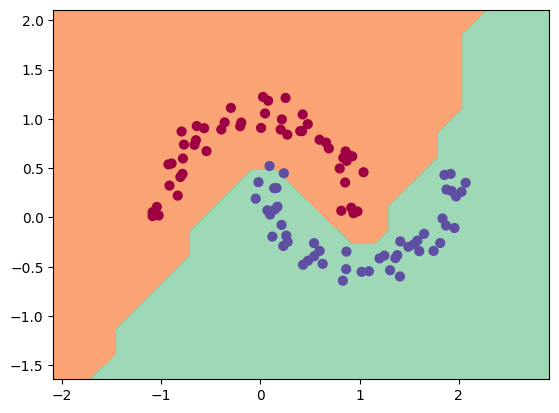

In [15]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs=torch.tensor(Xmesh).float()
scores=model(inputs)

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

Comme vous pouvez le voir, l'entraînement s'est bien passé et nous avons une bonne séparation des données. 